# 기초세팅

In [18]:
%cd drive/MyDrive/Colab\ Notebooks/HouseholdDebt

/content/drive/MyDrive/Colab Notebooks/HouseholdDebt


# 한글세팅

In [2]:
!sudo apt-get update -qq
!sudo apt-get install fonts-nanum* -qq

In [3]:
%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

In [4]:
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

NanumBarunGothic


In [5]:
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

In [6]:
import seaborn as sns

In [7]:
sns.set(font=font_name, 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [8]:
import pandas as pd

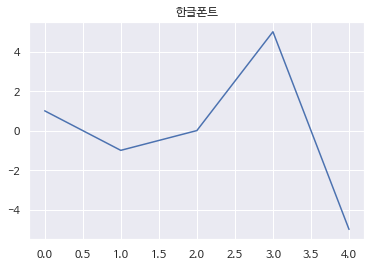

In [9]:
pd.Series([1, -1, 0, 5, -5]).plot(title="한글폰트")
None

In [10]:
!pip install statsmodels --upgrade

# 2030 신용대출 Dynamic Factors Model


In [17]:
import math
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ

## Data load

In [19]:
monthly_index = pd.date_range(start='2010-01-01', end='2021-12-31', freq='M')

In [20]:
df_monthly = pd.DataFrame(index=monthly_index)

In [21]:
quarterly_index = pd.date_range(start='2010-01-01', end='2021-09-30', freq='Q')

In [22]:
df_quarterly = pd.DataFrame(index=quarterly_index)

### macro data load

In [23]:
df_macro = pd.read_csv('data/all_monthly_macro_data.csv', index_col=0)

In [24]:
df_macro.index = pd.date_range(start='2010-01-31', end='2021-12-31', freq='M')

In [25]:
df_monthly['credit_loan_ir'] = df_macro['credit_loan_ir']

In [26]:
df_ur = pd.read_csv('data/월별_성_연령별_실업률.csv')

In [27]:
df_monthly['unemployment_rate'] = list(df_ur[(df_ur['성별']=='계') & (df_ur['연령계층별']=='계')]['데이터'])

### Loan data load

In [28]:
df_loan = pd.read_csv('data/house_loan_v2.csv')

In [29]:
df_quarterly['credit_loan_2030'] = list(df_loan[(df_loan['연령대'].isin(['20대', '30대'])) & (df_loan['상품구분(KFB)명'] == '신용대출')].groupby('기준분기').sum()['총금액 <Sum>'] / df_loan[(df_loan['연령대'].isin(['20대', '30대'])) & (df_loan['상품구분(KFB)명'] == '신용대출')].groupby('기준분기').sum()['소득추정금액 <Sum>'])

In [30]:
df_quarterly

,credit_loan_2030
2010-03-31,0.481912
2010-06-30,0.496228
2010-09-30,0.502845
2010-12-31,0.512095
2011-03-31,0.506489
2011-06-30,0.534508
2011-09-30,0.553714
2011-12-31,0.580176
2012-03-31,0.598876
2012-06-30,0.616404


### Transaction data load

In [31]:
df_crypto = pd.read_csv('data/crypto_monthly.csv', index_col=0)

In [32]:
df_crypto.index = pd.date_range(start='2016-01-31', end='2021-12-31', freq='M')

In [33]:
df_transaction = pd.DataFrame(index=pd.date_range(start='2010-01-31', end='2021-12-31', freq='M'))

In [34]:
df_monthly['krx_transaction'] = df_macro['krx_transaction']
df_monthly['crypto_krw_transaction'] = df_crypto['crypto_krw_transaction']

In [35]:
df_monthly = df_monthly.fillna(0)

In [36]:
df_monthly

,credit_loan_ir,unemployment_rate,krx_transaction,crypto_krw_transaction
2010-01-31,7.64,5.0,258243163.0,0.000000e+00
2010-02-28,7.41,4.8,163736548.0,0.000000e+00
2010-03-31,7.42,4.1,193438213.0,0.000000e+00
2010-04-30,7.01,3.7,209766895.0,0.000000e+00
2010-05-31,6.27,3.2,198346507.0,0.000000e+00
...,...,...,...,...
2021-08-31,3.97,2.6,834978945.0,5.378122e+13
2021-09-30,4.15,2.7,674180430.0,4.564198e+13
2021-10-31,4.62,2.8,607106382.0,6.369000e+13
2021-11-30,5.16,2.6,756235829.0,6.480509e+13


### Visualization

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
def visualize(df_list):
  df_scaled_list = map(lambda df: pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index), df_list)

  plt.figure(figsize=(15, 8))
  for df in df_scaled_list:
    sns.lineplot(data=df)
  plt.show()
  None

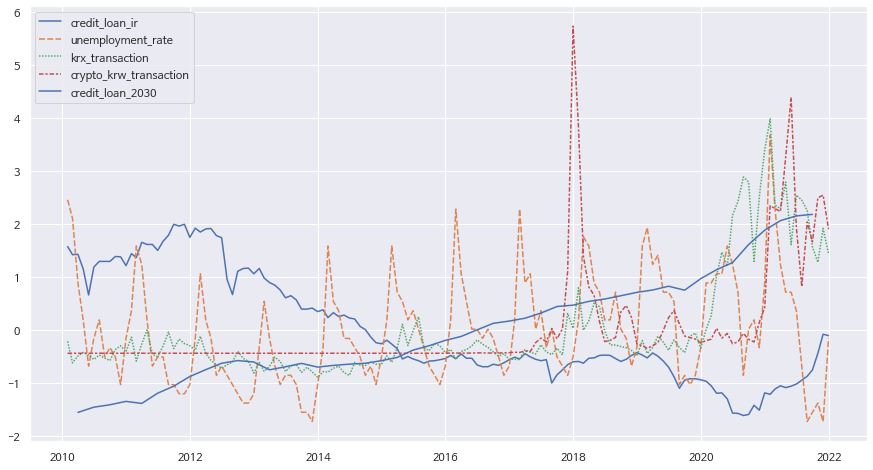

In [39]:
visualize([df_monthly, df_quarterly])

### Select variable and cut

In [40]:
df_monthly = df_monthly.loc['2016-12-31':]
df_quarterly = df_quarterly.loc['2016-12-31':]

In [41]:
df_monthly

,credit_loan_ir,unemployment_rate,krx_transaction,crypto_krw_transaction
2016-12-31,4.44,3.2,178731804.0,2.168174e+11
2017-01-31,4.51,3.7,179801830.0,4.028661e+11
2017-02-28,4.46,4.9,177693228.0,3.329007e+11
2017-03-31,4.61,4.1,221550238.0,9.061650e+11
2017-04-30,4.52,4.2,210928906.0,6.900096e+11
...,...,...,...,...
2021-08-31,3.97,2.6,834978945.0,5.378122e+13
2021-09-30,4.15,2.7,674180430.0,4.564198e+13
2021-10-31,4.62,2.8,607106382.0,6.369000e+13
2021-11-30,5.16,2.6,756235829.0,6.480509e+13


In [42]:
df_quarterly

,credit_loan_2030
2016-12-31,0.731873
2017-03-31,0.739673
2017-06-30,0.753709
2017-09-30,0.771654
2017-12-31,0.775354
2018-03-31,0.785686
2018-06-30,0.792134
2018-09-30,0.801074
2018-12-31,0.810351
2019-03-31,0.816840


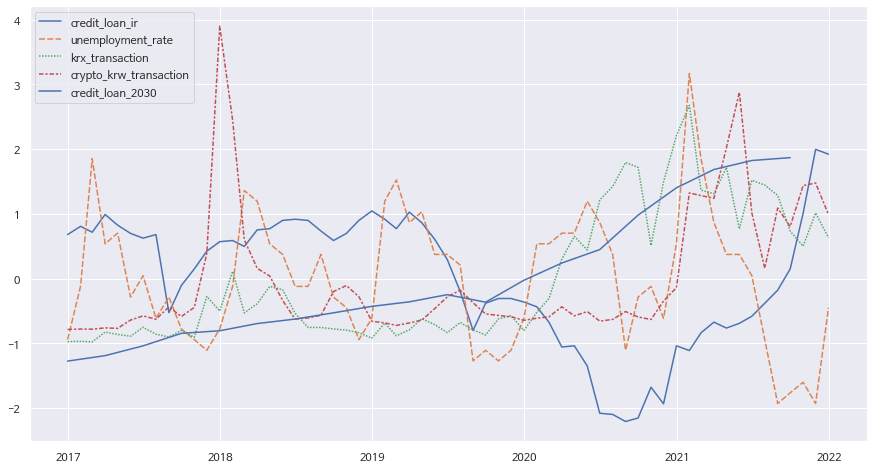

In [43]:
df_monthly_scaled = pd.DataFrame(StandardScaler().fit_transform(df_monthly), columns=df_monthly.columns, index=df_monthly.index)
df_quarterly_scaled = pd.DataFrame(StandardScaler().fit_transform(df_quarterly), columns=df_quarterly.columns, index=df_quarterly.index)
plt.figure(figsize = (15,8))
sns.lineplot(data=df_monthly_scaled)
sns.lineplot(data=df_quarterly_scaled)
plt.show()
None

### log

In [44]:
df_monthly_log = df_monthly.copy()
for col in df_monthly_log.columns:
  #if col in ['credit_loan_ir']:
  #  print(col)
  #  continue
  df_monthly_log[col] = df_monthly[col].apply(np.log)

In [45]:
df_quarterly_log = df_quarterly.copy()
for col in df_quarterly_log.columns:
  df_quarterly_log[col] = df_quarterly[col].apply(np.log)

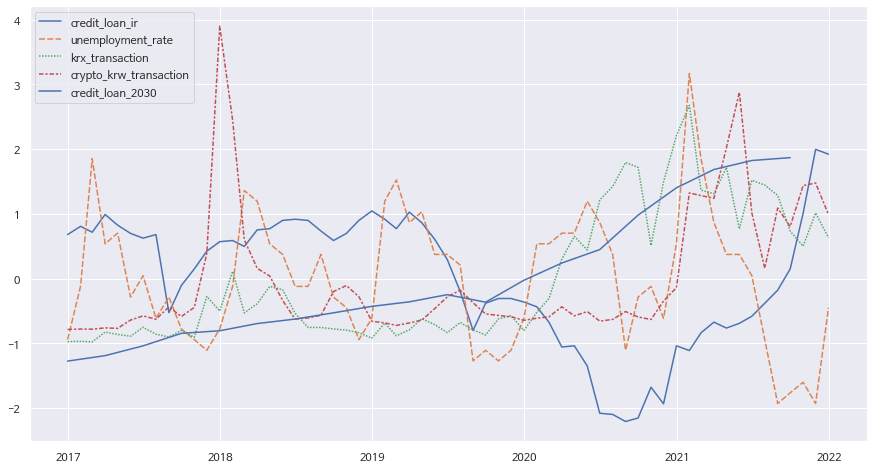

In [46]:
df_monthly_log_scaled = pd.DataFrame(StandardScaler().fit_transform(df_monthly_log), columns=df_monthly.columns, index=df_monthly.index)
df_quarterly_log_scaled = pd.DataFrame(StandardScaler().fit_transform(df_quarterly_log), columns=df_quarterly.columns, index=df_quarterly.index)
plt.figure(figsize = (15,8))
sns.lineplot(data=df_monthly_scaled)
sns.lineplot(data=df_quarterly_scaled)
plt.show()
None

In [47]:
df_monthly_log

,credit_loan_ir,unemployment_rate,krx_transaction,crypto_krw_transaction
2016-12-31,1.490654,1.163151,19.001397,26.102321
2017-01-31,1.506297,1.308333,19.007366,26.721870
2017-02-28,1.495149,1.589235,18.995569,26.531110
2017-03-31,1.528228,1.410987,19.216160,27.532487
2017-04-30,1.508512,1.435085,19.167032,27.259971
...,...,...,...,...
2021-08-31,1.378766,0.955511,20.542917,31.615945
2021-09-30,1.423108,0.993252,20.329008,31.451849
2021-10-31,1.530395,1.029619,20.224215,31.785049
2021-11-30,1.640937,0.955511,20.443864,31.802405


In [48]:
df_quarterly_log

,credit_loan_2030
2016-12-31,-0.312148
2017-03-31,-0.301547
2017-06-30,-0.282749
2017-09-30,-0.259219
2017-12-31,-0.254435
2018-03-31,-0.241198
2018-06-30,-0.233024
2018-09-30,-0.221802
2018-12-31,-0.210288
2019-03-31,-0.202312


## Diff

In [49]:
def convert_log_data_to_freq_over_freq(df, freq):
  a = np.array(df)
  df_qoq = pd.DataFrame(data=(a[freq:] - a[:-freq]) ,index=df.index[freq:], columns=df.columns)
  return df_qoq


### QOQ

In [50]:
df_quarterly_log_qoq = convert_log_data_to_freq_over_freq(df_quarterly_log, 1)

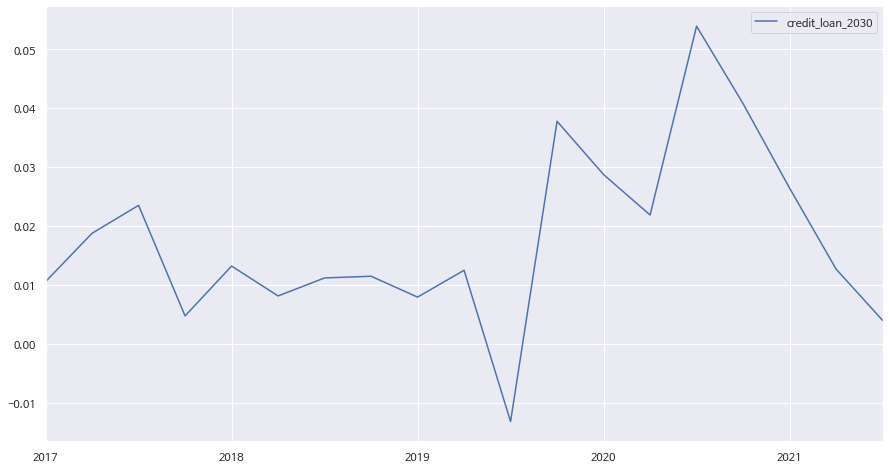

In [51]:
df_quarterly_log_qoq.plot(figsize=(15, 8))

In [52]:
df_monthly_log_qoq = convert_log_data_to_freq_over_freq(df_monthly_log, 3)

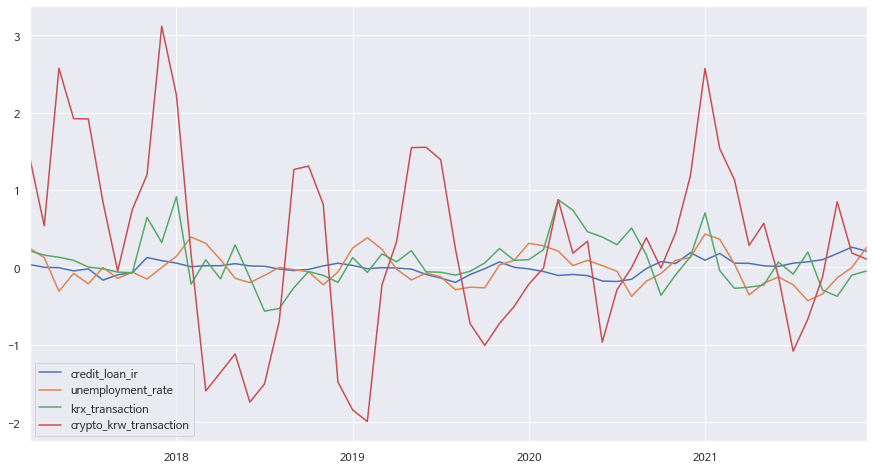

In [53]:
df_monthly_log_qoq.plot(figsize=(15, 8))

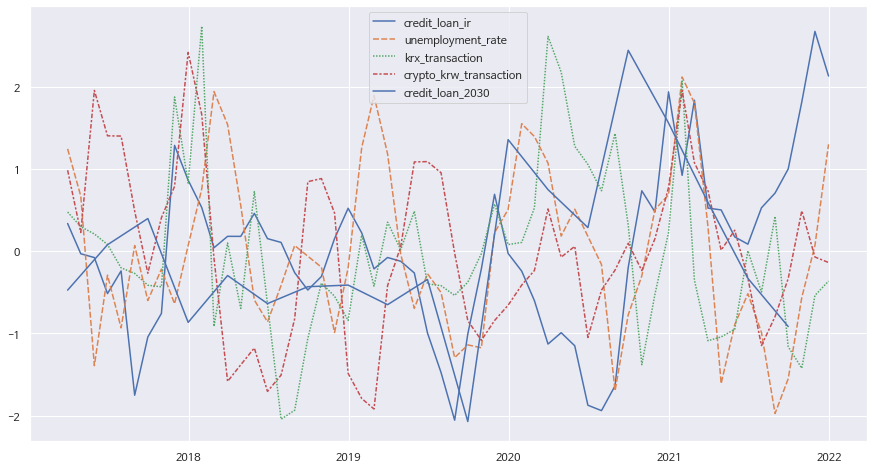

In [54]:
df_monthly_scaled = pd.DataFrame(StandardScaler().fit_transform(df_monthly_log_qoq), columns=df_monthly.columns, index=df_monthly_log_qoq.index)
df_quarterly_scaled = pd.DataFrame(StandardScaler().fit_transform(df_quarterly_log_qoq), columns=df_quarterly.columns, index=df_quarterly_log_qoq.index)
plt.figure(figsize = (15,8))
sns.lineplot(data=df_monthly_scaled)
sns.lineplot(data=df_quarterly_scaled)
plt.show()
None

### YOY

In [55]:
df_quarterly_log_yoy = convert_log_data_to_freq_over_freq(df_quarterly_log, 4)

In [56]:
df_monthly_log_yoy = convert_log_data_to_freq_over_freq(df_monthly_log, 12)

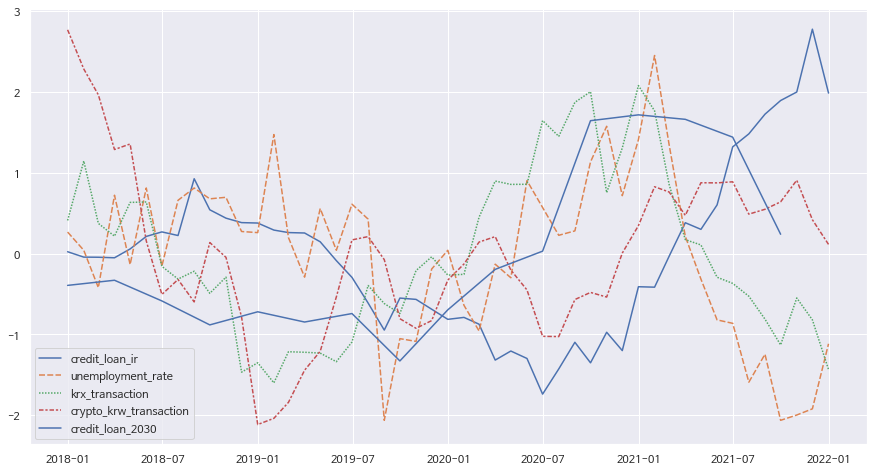

In [57]:
visualize([df_monthly_log_yoy, df_quarterly_log_yoy])

## Unit root test

In [58]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

### Original series

In [59]:
for name, column in df_monthly.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

for name, column in df_quarterly.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "credit_loan_ir" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3863
 No. Lags Chosen       = 2
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.5888. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "unemployment_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6809
 No. Lags Chosen       = 10
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.441. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "krx_transaction" 
    -----------------------------------------------


### Log series

In [60]:
for name, column in df_monthly_log.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')
  
for name, column in df_quarterly_log.iteritems():
  adfuller_test(column, name=column.name)
  print('\n')

    Augmented Dickey-Fuller Test on "credit_loan_ir" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4635
 No. Lags Chosen       = 2
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.5515. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "unemployment_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5186
 No. Lags Chosen       = 10
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.5243. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "krx_transaction" 
    -----------------------------------------------

### Log qoq series

In [61]:
for name, column in df_monthly_log_qoq.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

for name, column in df_quarterly_log_qoq.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "credit_loan_ir" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.7512
 No. Lags Chosen       = 11
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.833. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "unemployment_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6915
 No. Lags Chosen       = 11
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.4355. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "krx_transaction" 
    -----------------------------------------------

### Log yoy series

In [62]:
for name, column in df_monthly_log_yoy.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

for name, column in df_quarterly_log_yoy.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "credit_loan_ir" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.004
 No. Lags Chosen       = 11
 Critical value 1%     = -3.621
 Critical value 5%     = -2.944
 Critical value 10%    = -2.61
 => P-Value = 0.0014. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "unemployment_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.7291
 No. Lags Chosen       = 8
 Critical value 1%     = -3.606
 Critical value 5%     = -2.937
 Critical value 10%    = -2.607
 => P-Value = 0.0037. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "krx_transaction" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

## Dynamic factors model

### Define endog, exog

In [ ]:
endog = df_monthly_log_yoy.join([df_quarterly_log_yoy])
endog = endog.drop(columns=['credit_loan_ir', 'unemployment_rate'])

In [ ]:
endog_std = pd.DataFrame(StandardScaler().fit_transform(endog), index=endog.index, columns=endog.columns)

In [ ]:
endog_std

,krx_transaction,crypto_krw_transaction,credit_loan_2030
2017-12-31,0.409275,2.767959,-0.394202
2018-01-31,1.144394,2.283372,NaN
2018-02-28,0.372578,1.963494,NaN
2018-03-31,0.215153,1.286787,-0.330721
2018-04-30,0.632444,1.355275,NaN
2018-05-31,0.637976,0.156513,NaN
2018-06-30,-0.158664,-0.506397,-0.586564
2018-07-31,-0.315865,-0.321522,NaN
2018-08-31,-0.219148,-0.598474,NaN
2018-09-30,-0.492101,0.135847,-0.882969


In [ ]:
exog = df_monthly_log_yoy[['credit_loan_ir', 'unemployment_rate']].copy()

In [ ]:
exog_std = pd.DataFrame(StandardScaler().fit_transform(exog), index=exog.index, columns=exog.columns)

In [ ]:
exog_std

,credit_loan_ir,unemployment_rate
2017-12-31,0.022106,0.265363
2018-01-31,-0.044475,0.040326
2018-02-28,-0.046002,-0.421709
2018-03-31,-0.052631,0.721108
2018-04-30,0.056718,-0.135902
2018-05-31,0.211570,0.810841
2018-06-30,0.267476,-0.154702
2018-07-31,0.222779,0.658705
2018-08-31,0.925323,0.810841
2018-09-30,0.541024,0.676651


### Molel build

In [ ]:
mod = DynamicFactor(endog=endog_std, k_factors=1, factor_order=2, exog=exog_std, error_order=1) # 172
#mod = DynamicFactor(endog=endog_std, k_factors=1, factor_order=1, exog=None, error_order=1) # 172

### Parameter estimation

In [ ]:
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)

In [ ]:
print(res.summary(separate_params=False))

                                                   Statespace Model Results                                                  
Dep. Variable:     ['krx_transaction', 'crypto_krw_transaction', 'credit_loan_2030']   No. Observations:                   49
Model:                                             DynamicFactor(factors=1, order=2)   Log Likelihood                 -65.672
                                                                      + 1 regressors   AIC                            159.344
                                                                      + AR(1) errors   BIC                            185.829
Date:                                                               Wed, 23 Feb 2022   HQIC                           169.392
Time:                                                                       08:13:42                                         
Sample:                                                                   12-31-2017                                  

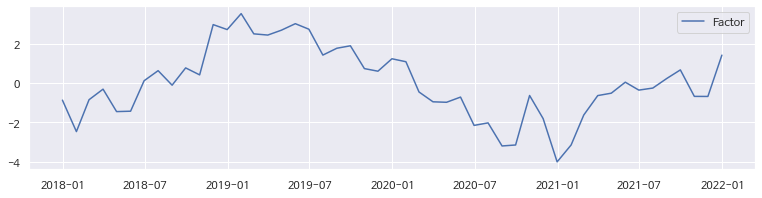

In [ ]:
fig, ax = plt.subplots(figsize=(13,3))

dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()

### Forecasts

In [ ]:
res.forecast(steps=12)

,krx_transaction,crypto_krw_transaction,credit_loan_2030
2021-10,-0.273127,1.796467,0.072807
2021-11,-0.201363,1.567789,0.067926
2021-12,-0.137777,1.382158,0.067536
2022-01,-0.081437,1.231469,0.068711
2022-02,-0.031517,1.109143,0.070098
2022-03,0.012714,1.009841,0.071188
2022-04,0.051905,0.929227,0.072044
2022-05,0.086629,0.863784,0.072716
2022-06,0.117397,0.810656,0.073244
2022-07,0.144658,0.767525,0.073659


Text(0.5, 1.0, 'Forecast')

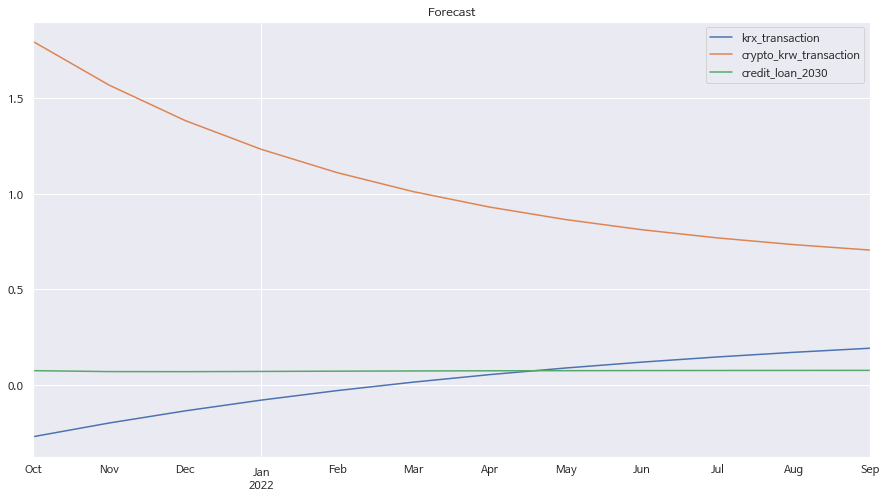

In [ ]:
res.forecast(steps=12).plot(figsize=(15,8)).set_title('Forecast')

### Structural analysis

#### Impulse response analysis

In [ ]:
res.impulse_responses(steps=12)

,krx_transaction,crypto_krw_transaction,credit_loan_2030
0,0.427608,1.360748,0.002809
1,0.372216,1.184475,0.008062
2,0.323998,1.031037,0.015444
3,0.282027,0.897476,0.019061
4,0.245493,0.781216,0.019401
5,0.213692,0.680016,0.016887
6,0.186010,0.591926,0.014700
7,0.161914,0.515248,0.012796
8,0.140940,0.448502,0.011138
9,0.122682,0.390403,0.009695


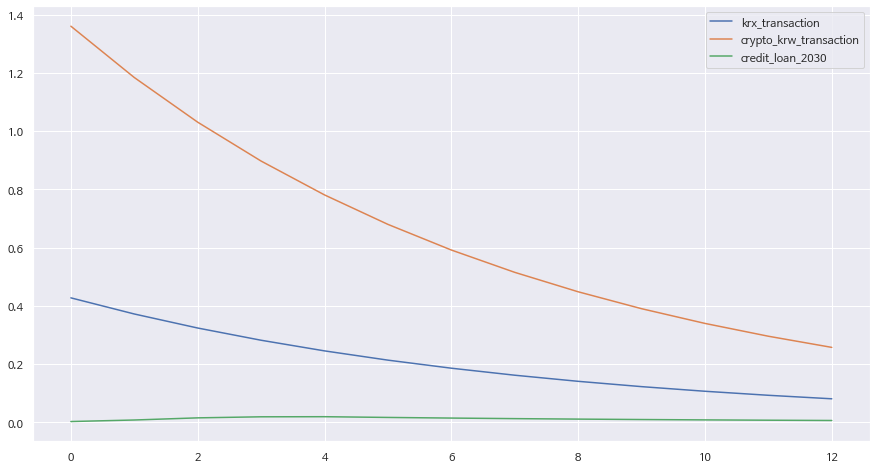

In [ ]:
res.impulse_responses(steps=12).plot(figsize=(15,8))

### Diagnostics

#### Testing for nonormality

In [ ]:
res.test_normality(method=None)[:, 1]

array([9.49514205e-01, 3.73900324e-03, 1.11414650e-61])

#### Checking for residual autocorrelation

In [ ]:
res.test_serial_correlation(method=None)[:, 1]

array([[0.61524456, 0.55016783, 0.57479114, 0.21153995, 0.14462153,
        0.20981513, 0.29710544, 0.2959097 , 0.37336858],
       [0.04412151, 0.08386594, 0.07813407, 0.05010438, 0.06445161,
        0.09793907, 0.08363975, 0.07749663, 0.02341914],
       [0.98943773, 0.99982124, 0.9827186 , 0.99669344, 0.99942576,
        0.98850705, 0.99603429, 0.9987107 , 0.83200711]])